In [1]:
import matplotlib.pyplot as plt
from rvseg import dataset

%matplotlib inline

Using TensorFlow backend.


In [2]:
data_dir = "/home/paperspace/Developer/datasets/RVSC/TrainingSet/"
data_dir = "/home/paperspace/Developer/software/cardiac-segmentation/test-assets/"

augmentation_args = {
    'rotation_range': 180,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'shear_range': 0.1,
    'zoom_range': 0.05,
    'fill_mode' : 'nearest',
    'alpha': 500,
    'sigma': 20,
    'samplewise_center': True,
    'samplewise_std_normalization': True,
}

(train_generator, train_steps_in_epoch,
 val_generator, val_steps_in_epoch) = dataset.create_generators(
    data_dir=data_dir,
    batch_size=16,
    validation_split=0.0,
    mask='both',
    augment_training=False,
    augment_validation=False,
    augmentation_args=augmentation_args)

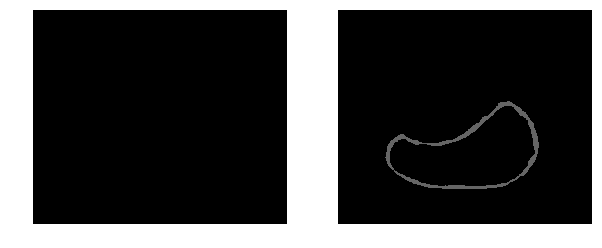

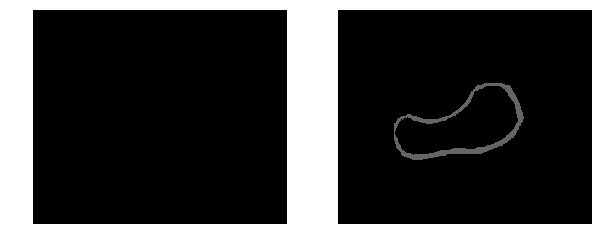

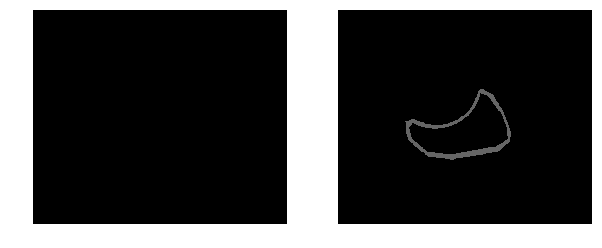

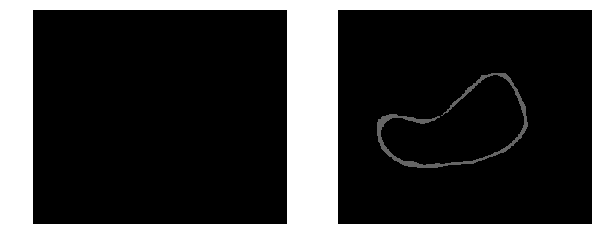

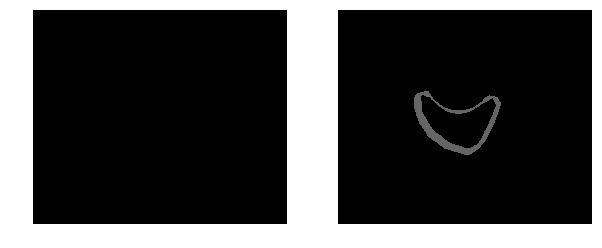

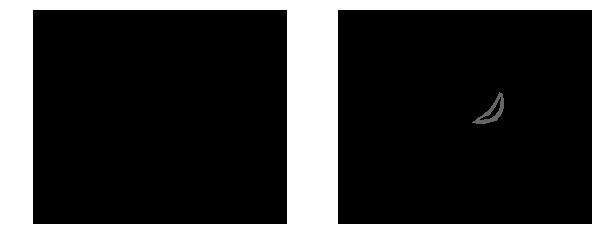

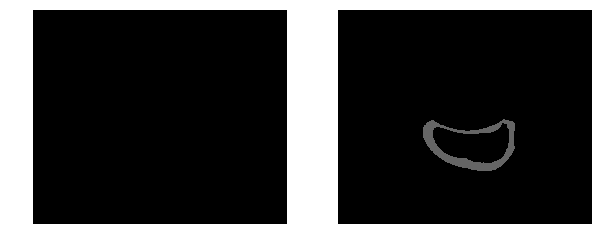

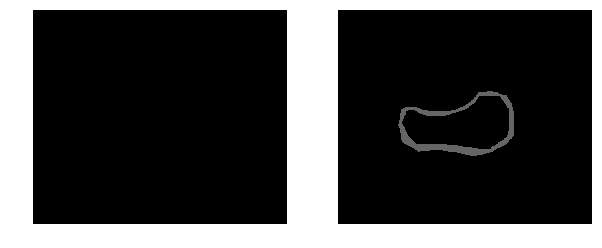

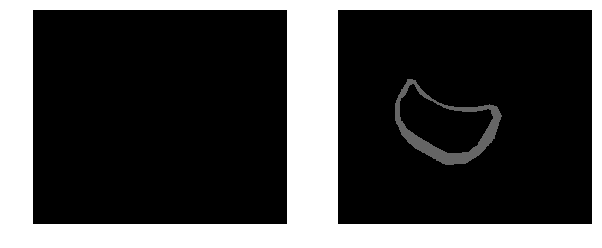

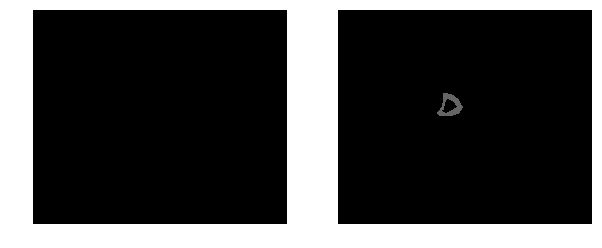

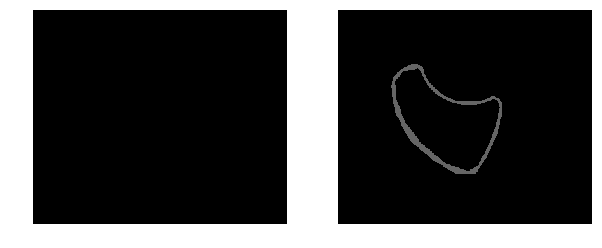

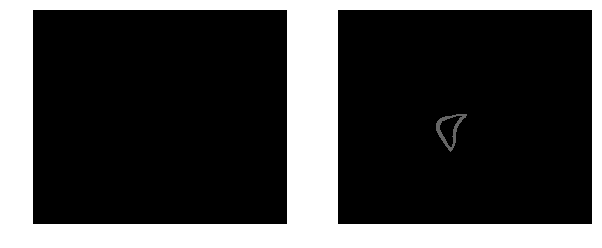

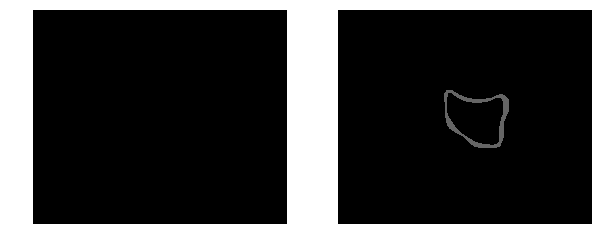

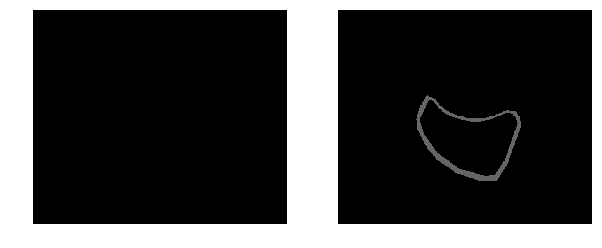

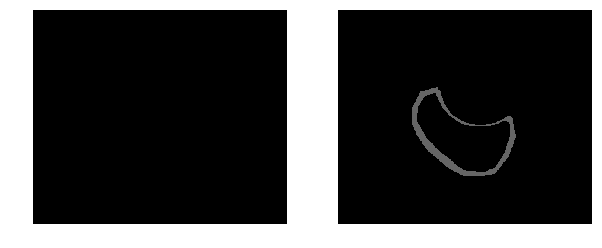

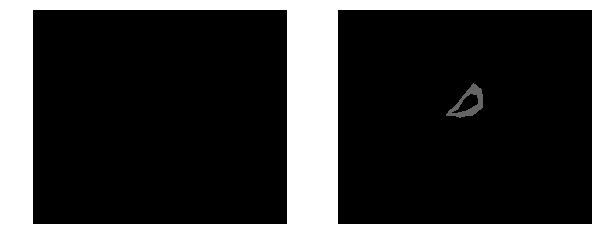

In [3]:
images, masks = next(train_generator)
for image,mask in zip(images, masks):
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.imshow(image[:,:,0], cmap=plt.cm.gray)
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.imshow(image[:,:,0], cmap=plt.cm.gray)
    plt.imshow(mask[:,:,1], cmap=plt.cm.gray, alpha=0.4)

In [49]:
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.                                                                                             
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for                                                                                           
       Convolutional Neural Networks applied to Visual Document Analysis", in                                                                                   
       Proc. of the International Conference on Document Analysis and                                                                                           
       Recognition, 2003.                                                                                                                                       
    """
    assert len(image.shape)==2

    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    print(dx.shape, dy.shape, x.shape, y.shape, indices[0].shape, indices[1].shape)

    return map_coordinates(image, indices, order=1).reshape(shape)


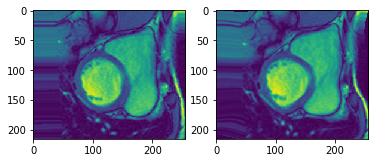

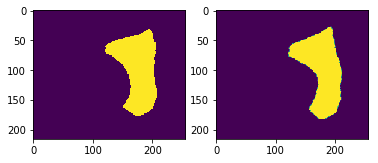

In [61]:
image = images[0,:,:,0]
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(elastic_transform(image, 500, 20))

mask = masks[0,:,:,1]
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(mask)
plt.subplot(1, 2, 2)
plt.imshow(elastic_transform(mask, 500, 20))

In [63]:
def random_elastic_deformation(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.                                                                                             
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for                                                                                           
       Convolutional Neural Networks applied to Visual Document Analysis", in                                                                                   
       Proc. of the International Conference on Document Analysis and                                                                                           
       Recognition, 2003.                                                                                                                                       
    """
    assert len(image.shape)==3

    if random_state is None:
        random_state = np.random.RandomState(None)

    height, width, channels = image.shape

    dx = gaussian_filter(2*random_state.rand(height, width) - 1,
                         sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter(2*random_state.rand(height, width) - 1,
                         sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    indices = (np.repeat(np.ravel(x+dx), 3),
               np.repeat(np.ravel(y+dy), 3),
               np.tile([0,1,2], height*width))

    return map_coordinates(image, indices, order=1).reshape((height, width, channels))


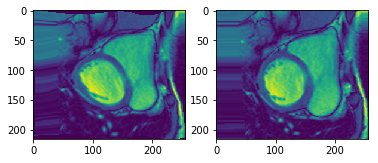

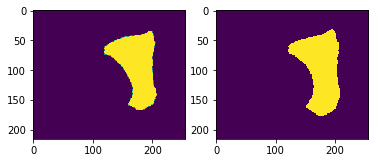

In [79]:
image0, mask0 = images[0,...], masks[0,...]
stacked = np.concatenate((image0, mask0), axis=2)
augmented = random_elastic_deformation(stacked, 500, 20)
image = augmented[:,:,0]
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(image0[:,:,0])

mask = augmented[:,:,2]
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(mask)
plt.subplot(1, 2, 2)
plt.imshow(mask0[:,:,1])